In [2]:
import os
import ROOT as r
import uproot

Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<std::vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 
Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 


Welcome to JupyROOT 6.24/07


In [3]:
class runInfo:
    
    def __init__(self, directory, runNum, fileNums):
        self.directory = directory
        self.run = runNum
        if isinstance(fileNums, list): self.files = fileNums
        else: self.files = [fileNums]
            
        self.totalEvents = 0
        self.unmatchedEvents = 0
    

In [4]:
def getRunFile(filename):
    runNum = filename.split('Run')[-1].split('.')[0]
    fileNum = filename.split('.')[1].split('_')[0]
    return runNum, fileNum

In [5]:
def printFileCounts():
    fout = open('fileCounts.csv', 'w')
    print("{0:<10} {1:>8} {2:>8} {3:>8} {4:>10} {5:>15} {6:>15} {7:>15}".format('Run', 'DAQ Files', 'Trig Files', 'Matched Files', 'Unmatched Files', 'Total Events', 'Unmatched Events', 'Frac Unmatched'))
    for key, value in daqFiles.items():
        numDAQ = len(daqFiles[key].files)
        numTrig = 0
        numMatched = 0
        missing = ''
        totalEvents, unmatched, frac = 0, 0, 0
        if key in trigFiles.keys(): numTrig = len(trigFiles[key].files)
        if key in matchedFiles.keys(): 
            numMatched = len(matchedFiles[key].files)
            totalEvents = matchedFiles[key].totalEvents
            unmatched = matchedFiles[key].unmatchedEvents
            if totalEvents != 0: frac = unmatched/totalEvents 
        if numDAQ != numMatched: missing = 'x'

        print("{0:<10} {1:>8} {2:>8} {3:>8} {4:>10} {5:>15} {6:>15} {7:>15.3f}".format(key, numDAQ, numTrig, numMatched, missing, totalEvents, unmatched, frac))
        fout.write('{0},{1},{2},{3},{4},{5},{6}\n'.format(key, numDAQ, numTrig, numMatched, missing, totalEvents, unmatched))
    fout.close()

In [6]:
def getFiles(directory, run, files, tree):
    filelist = ["{0}/MatchedEvents_Run{1}.{2}_rematch.root:{3}".format(directory, run, x, tree) for x in files]
    return filelist
    

In [7]:
def checkMatchedFiles(runInfo):
    filelist = getFiles(runInfo.directory, runInfo.run, runInfo.files, 'matchedTrigEvents')
    
    total_unmatched = 0
    for events in uproot.iterate(
    
        #files
        filelist,
        
        #branches
        ['trigger'],
        
        #cut
        #cut="",
        
        how="zip",
        
        step_size="1 MB",
        
        num_workers=4,
    
    ):
        
        unmatchedCut = events[:, "trigger"] == -1
        unmatched = events[unmatchedCut, "trigger"]
        h_unmatched.Fill(runInfo.run, len(unmatched))
        h_total.Fill(runInfo.run, len(events))
        runInfo.totalEvents += len(events)
        runInfo.unmatchedEvents += len(unmatched)
    
    return runInfo

In [11]:
if __name__ == "__main__":

    path = '/store/user/milliqan/run3/'
    directories = ['1000', '1100']
    subdirectories = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']

    daqFiles = {}
    trigFiles = {}
    matchedFiles = {}

    
    min_run = 1000
    max_run = 1170
    bins = max_run - min_run
    h_total = r.TH1F("h_total", "Total Number of Events in Run", bins, min_run, max_run)
    h_unmatched = r.TH1F("h_unmatched", "Number of Unmatched Events in Run", bins, min_run, max_run)

    c1  = r.TCanvas("c1", "c1", 800,800)

    for directory in directories:
        for sub in subdirectories:
            fullPath = path+directory+'/'+sub
            if not os.path.isdir(fullPath): continue
            for filename in os.listdir(fullPath):
                if not filename.endswith('.root'): continue
                if filename.startswith('MilliQan'):
                    runNum, fileNum = getRunFile(filename)
                    if runNum in daqFiles:
                        daqFiles[runNum].files.append(fileNum)
                    else:
                        daqFiles[runNum] = runInfo(fullPath, runNum, fileNum)
                elif filename.startswith('TriggerBoard'):
                    runNum, fileNum = getRunFile(filename)
                    if runNum in trigFiles:
                        trigFiles[runNum].files.append(fileNum)
                    else:
                        trigFiles[runNum] = runInfo(fullPath, runNum, fileNum)
                elif filename.startswith('MatchedEvents'):
                    if not 'rematch' in filename: continue
                    runNum, fileNum = getRunFile(filename)
                    if runNum in matchedFiles:
                        matchedFiles[runNum].files.append(fileNum)
                    else:
                        matchedFiles[runNum] = runInfo(fullPath, runNum, fileNum)
    
    for key, value in matchedFiles.items():
        #if int(key) > 1005: break
        matchedFiles[key] = checkMatchedFiles(value)
                 

    
    printFileCounts()


Run        DAQ Files Trig Files Matched Files Unmatched Files    Total Events Unmatched Events  Frac Unmatched
1000              9       10        9                       9000            9000           1.000
1001              6        6        6                       5671            5671           1.000
1002              6        6        6                       5149            5149           1.000
1003              7        7        7                       6645            6645           1.000
1004              2        2        2                       1468            1468           1.000
1005              4        4        4                       3184               1           0.000
1006           3236     3253     3236                    3235088            2139           0.001
1007             83       83       83                      82154              54           0.001
1008              7        7        7                       6436               8           0.001
1009            

Warning in <TROOT::Append>: Replacing existing TH1: h_total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_unmatched (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [ ]:
h_ratio = h_unmatched.Clone()
h_ratio.Divide(h_total)
h_ratio.Draw()
c1.SetLogy()
c1.Draw()

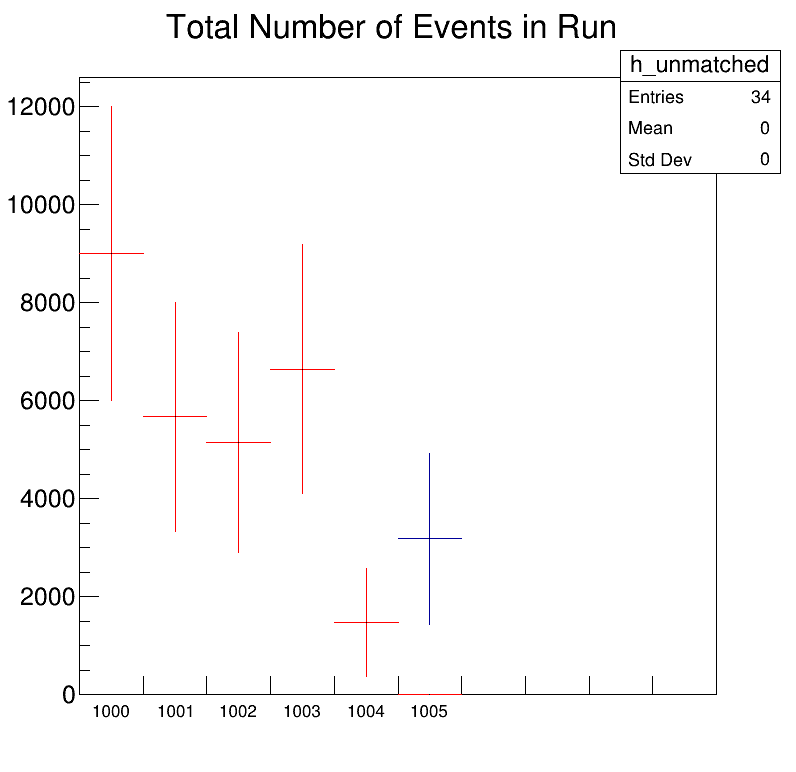

In [67]:
h_total.Draw()
h_unmatched.SetLineColor(2)
h_unmatched.Draw("same")
c1.SetLogy(0)
c1.Draw()


In [78]:
matchedFiles['1000'].unmatchedEvents

9000